In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(1337)

# load custom ipython formatting (ignore this)
from IPython.core.display import display, HTML
display(HTML(open('custom.html').read()))

kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal',
        'size'   : 24}
matplotlib.rc('font', **font)

def error_plot(ys, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys, **kwargs)

# Some applications of gradient methods

In this note, we'll solve some optimization problems using the gradient methods we've seen so far.

* Projected gradient descent
* Quadratics
* Least squares
* LASSO
* Support Vector Machines


## Projected gradient descent

We start with a basic implementation of projected gradient descent.

In [2]:
def gradient_descent(init, steps, grad, proj=lambda x: x):
    """Projected gradient descent.
    
    Inputs:
        initial: starting point
        steps: list of scalar step sizes
        grad: function mapping points to gradients
        proj (optional): function mapping points to points
        
    Returns:
        List of all points computed by projected gradient descent.
    """
    xs = [init]
    for step in steps:
        xs.append(proj(xs[-1] - step * grad(xs[-1])))
    return xs

Note that this implementation keeps around all points computed along the way. This is clearly not what you would do on large instances. We do this for illustrative purposes to be able to easily inspect the computed sequence of points.

## Optimizing a quadratic

As a toy example, let's optimize $$f(x)=\frac12\|x\|^2,$$ which has the gradient map $\nabla f(x)=x.$

In [3]:
def quadratic(x):
    return 0.5*x.dot(x)

def quadratic_gradient(x):
    return x

Note the function is $1$-smooth. Our theorems would then suggest that we use a constant step size of $1.$ If you think about, for this step the algorithm will actually find the optimal solution in just one step.

In [4]:
x0 = np.random.normal(0, 1, (1000))
_, x1 = gradient_descent(x0, [1], quadratic_gradient)

Indeed, it does.

In [5]:
x1.all() == 0

True

Let's say we don't have the right learning rate. 

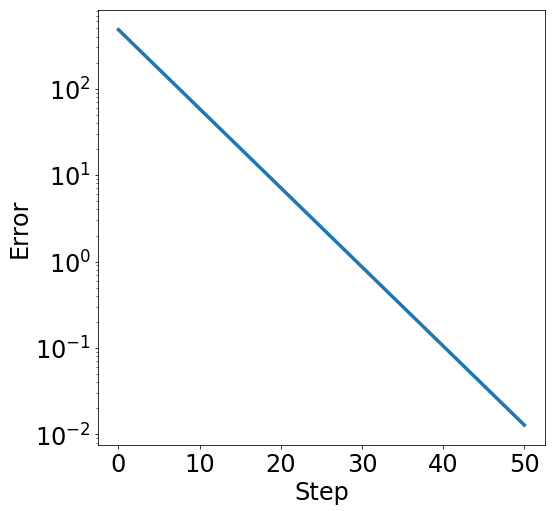

In [6]:
xs = gradient_descent(x0, [0.1]*50, quadratic_gradient)
error_plot([quadratic(x) for x in xs])

## Constrained optimization

Let's say we want to optimize the function inside some affine subspace. Recall that affine subspaces are convex sets. Below we pick a random low dimensional affine subspace $b+U$ and define the corresponding linear projection operator.

In [7]:
U = np.linalg.qr(np.random.normal(0, 1, (1000, 10)))[0]
b = np.random.normal(0, 1, 1000)
def proj(x):
    """Projection of x onto an affine subspace"""
    return b + (np.eye(1000)-U.dot(U.T)).dot(x-b)

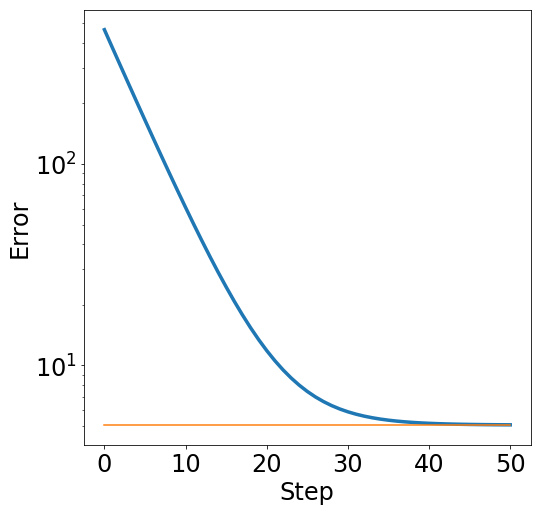

In [8]:
x0 = np.random.normal(0, 1, (1000))
xs = gradient_descent(x0, [0.1]*50, quadratic_gradient, proj)
x_opt = proj(0)
error_plot([quadratic(x) for x in xs])
plt.plot(range(len(xs)), [quadratic(x_opt)]*len(xs))

## Least Squares 

One of the most fundamental data analysis tools is *linear least squares*. Given an $m\times n$ matrix $A$ and a vector $b$ our goal is to find a vector $x\in\mathbb{R}^n$ that minimizes the following objective:

$$
\frac 1{2m}\sum_{i=1}^m (a_i^\top x - b_j)^2 
=\frac1{2m}\|Ax-b\|^2
$$

In [9]:
def least_squares(A, b, x):
    return (0.5/m) * np.linalg.norm(A.dot(x)-b)**2

def least_squares_gradient(A, b, x):
    return np.ones(m).dot(np.diag(A.dot(x)-b).dot(A))/m

### Overdetermined case $m\ge n$

In [10]:
m, n = 100, 100
A = np.random.normal(0, 1, (m, n))
x_opt = np.random.normal(0, 1, n)
noise = np.random.normal(0, 0.1, m)
b = A.dot(x_opt) + noise
objective = lambda x: least_squares(A, b, x)
gradient = lambda x: least_squares_gradient(A, b, x)

#### Convergence in error

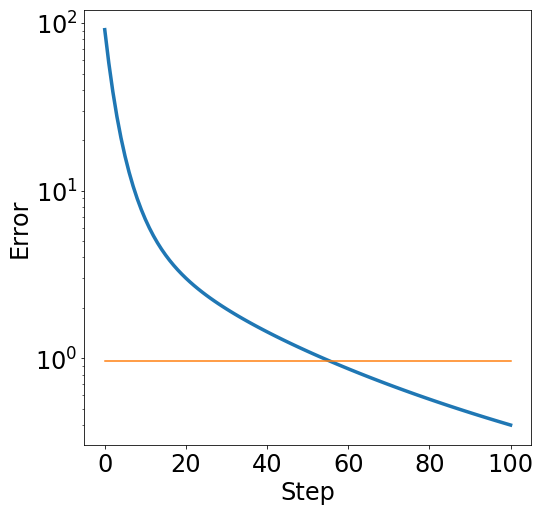

In [11]:
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*100, gradient)
error_plot([objective(x) for x in xs])
_ = plt.plot(range(len(xs)), [np.linalg.norm(noise)**2]*len(xs))

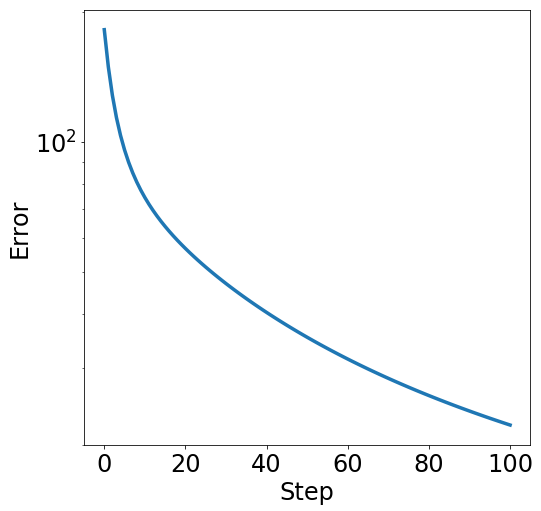

In [12]:
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs])

### Underdetermined case $m < n$

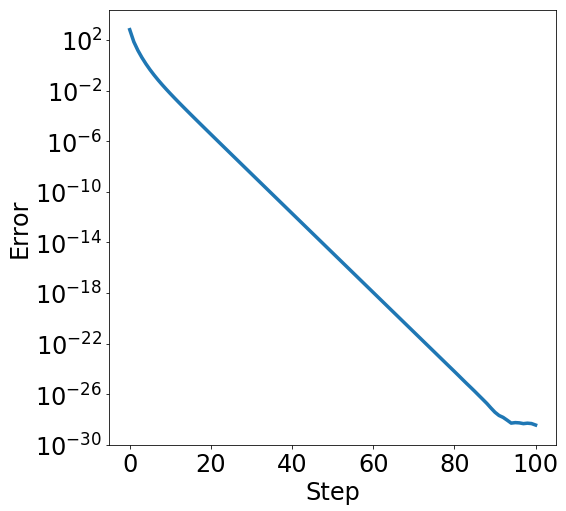

In [13]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
x_opt = np.random.normal(0, 1, n)
b = A.dot(x_opt)
objective = lambda x: least_squares(A, b, x)
gradient = lambda x: least_squares_gradient(A, b, x)
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*100, gradient)
error_plot([objective(x) for x in xs])

While we quickly reduce the error, we don't actually converge in domain. This is just because the function is no longer strongly convex in the underdetermined case.

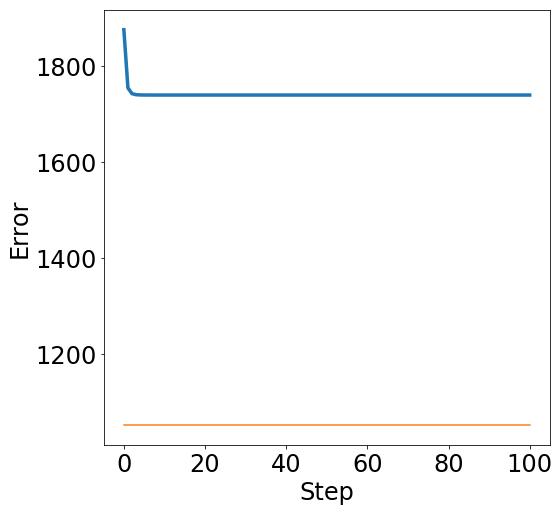

In [14]:
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs], yscale='linear')
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs))

## $\ell_2$-regularized least squares

$$
\frac1{2m}\|Ax-b\|^2 + \frac{\alpha}2\|x\|^2
$$


In [15]:
def least_squares_l2(A, b, x, alpha=0.1):
    return least_squares(A, b, x) + (alpha/2) * x.dot(x)

def least_squares_l2_gradient(A, b, x, alpha=0.1):
    return least_squares_gradient(A, b, x) + alpha * x

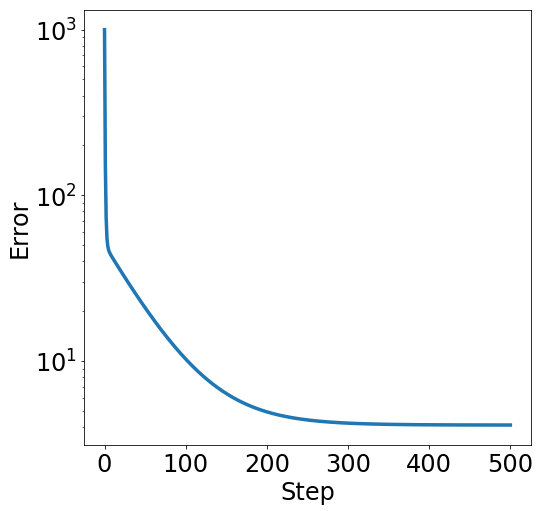

In [16]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
x_opt = np.random.normal(0, 1, n)
b = A.dot(x_opt)
objective = lambda x: least_squares_l2(A, b, x)
gradient = lambda x: least_squares_l2_gradient(A, b, x)
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*500, gradient)
error_plot([objective(x) for x in xs])

You see that the error doesn't decrease below a certain level due to the regularization term. This is not a bad thing. In fact, the regularization term gives as *strong convexity* which leads to convergence in domain again:

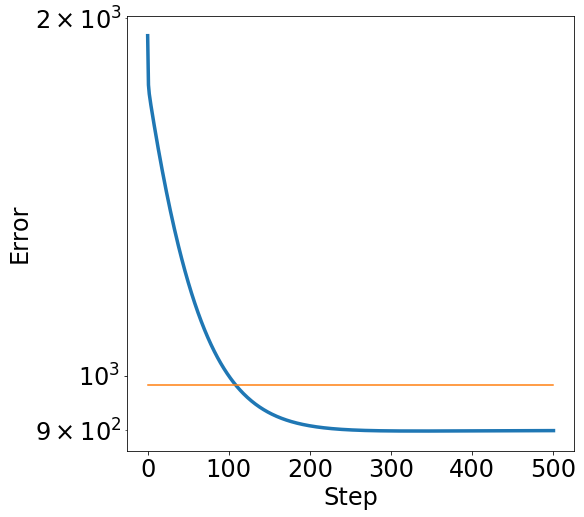

In [17]:
xs = gradient_descent(x0, [0.1]*500, gradient)
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs])
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs))

## LASSO

LASSO is the name for $\ell_1$-regularized least squares regression:

$$\frac1{2m}\|Ax-b\|^2 + \alpha\|x\|_1$$

We will see that LASSO is able to fine *sparse* solutions if they exist.

In [18]:
def lasso(A, b, x, alpha=0.1):
    return least_squares(A, b, x) + alpha * np.linalg.norm(x, 1)

def ell1_subgradient(x):
    """Subgradient of the ell1-norm at x."""
    g = np.ones(x.shape)
    g[x < 0.] = -1.0
    return g

def lasso_subgradient(A, b, x, alpha=0.1):
    """Subgradient of the lasso objective at x"""
    return least_squares_gradient(A, b, x) + alpha*ell1_subgradient(x)

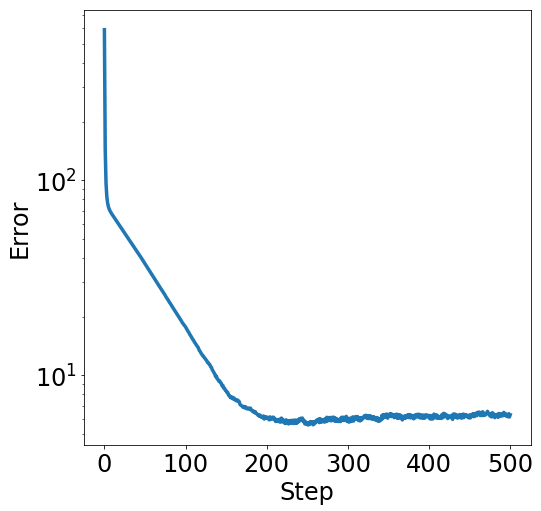

In [19]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
x_opt = np.zeros(n)
x_opt[:10] = 1.0
b = A.dot(x_opt)
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*500, lambda x: lasso_subgradient(A, b, x))
error_plot([lasso(A, b, x) for x in xs])

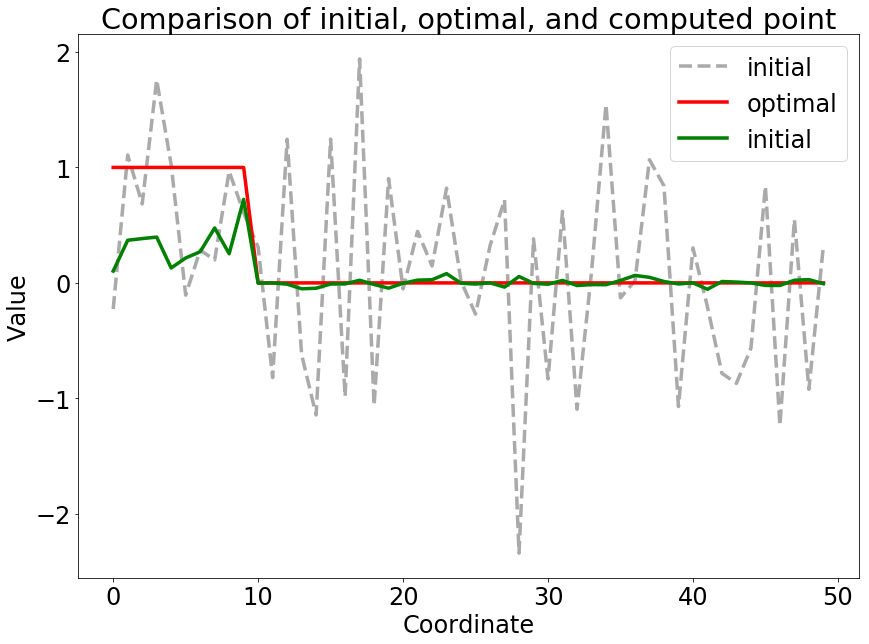

In [20]:
plt.figure(figsize=(14,10))
plt.title('Comparison of initial, optimal, and computed point')
idxs = range(50)
plt.plot(idxs, x0[idxs], '--', color='#aaaaaa', label='initial', **kwargs)
plt.plot(idxs, x_opt[idxs], 'r-', label='optimal', **kwargs)
plt.plot(idxs, xs[-1][idxs], 'g-', label='initial', **kwargs)
plt.xlabel('Coordinate')
plt.ylabel('Value')
plt.legend()

As promised, LASSO correctly identifies the significant coordinates of the optimal solution. This is why, in practice, LASSO is a popular tool for feature selection.

Play around with this plot to inspect other points along the way, e.g., the point that achieves lowest objective value.

## Support Vector Machines

In a linear classification problem, we're given $m$ labeled points $(a_i, y_i)$ and we wish to find a hyperplane given by a point $x$ that separates them so that 

* $\langle a_i, x\rangle \ge 1$ when $y_i=1$, and 
* $\langle a_i, x\rangle \le -1$ when $y_i = -1$

The smaller the norm $\|x\|$ the larger the *margin* between positive and negative instances. Therefore, it makes sense to throw in a regularizer that penalizes large norms. This leads to the objective.

$$\frac 1m \sum_{i=1}^m \max\{1-y_i(a_i^\top x), 0\} + \frac{\alpha}2\|x\|^2$$

In [21]:
def hinge_loss(z):
    return np.maximum(1.-z, np.zeros(z.shape))

def svm_objective(A, y, x, alpha=0.1):
    """SVM objective."""
    m, _ = A.shape
    return np.mean(hinge_loss(np.diag(y).dot(A.dot(x))))+alpha*x.dot(x)

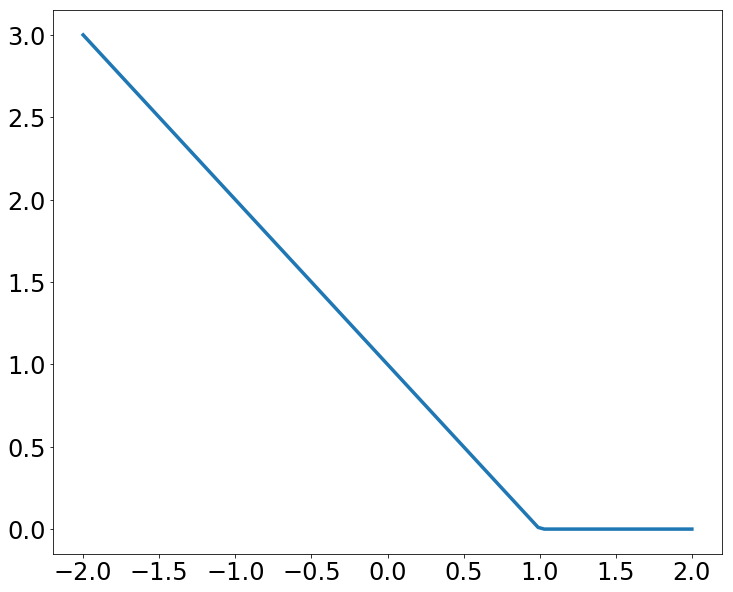

In [22]:
z = np.linspace(-2, 2, 100)
plt.figure(figsize=(12,10))
plt.plot(z, hinge_loss(z), **kwargs)

In [23]:
def hinge_subgradient(z):
    g = np.zeros(z.shape)
    g[z < 1] = -1.
    return g

def svm_subgradient(A, y, x, alpha=0.1):
    g1 = hinge_subgradient(np.diag(y).dot(A.dot(x)))
    g2 = np.diag(y).dot(A)
    return g1.dot(g2) + alpha*x

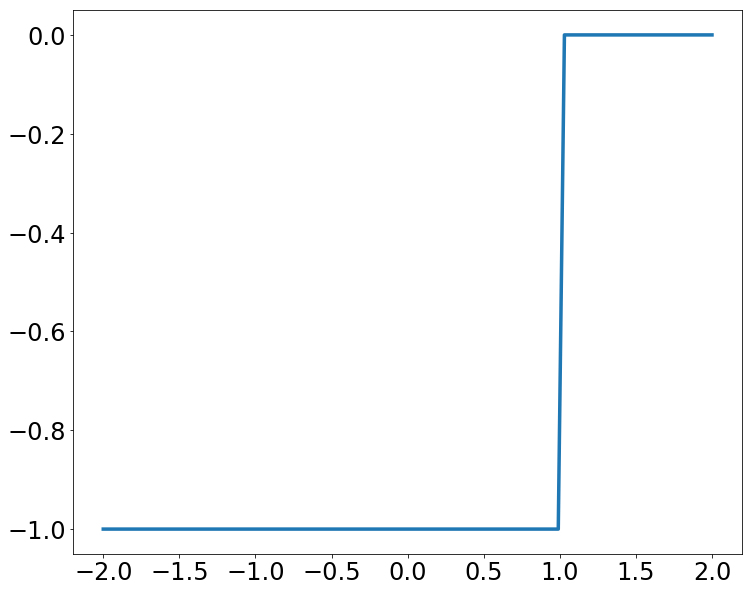

In [24]:
plt.figure(figsize=(12,10))
plt.plot(z, hinge_subgradient(z), **kwargs)

In [25]:
m, n = 1000, 100
A = np.vstack([np.random.normal(0.1, 1, (m//2, n)),
               np.random.normal(-0.1, 1, (m//2, n))])
y = np.hstack([np.ones(m//2), -1.*np.ones(m//2)])
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*50, lambda x: svm_subgradient(A, y, x))

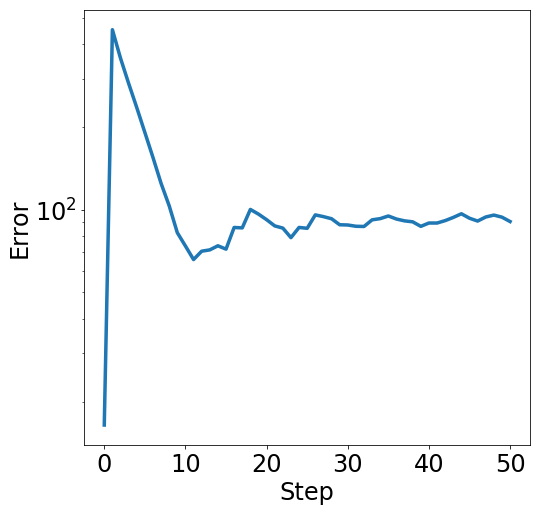

In [26]:
error_plot([svm_objective(A, y, x) for x in xs])

In [27]:
svm_objective(A, y, xs[0])

16.438781634274328

In [28]:
def accuracy(A, y, x):
    return np.mean(np.diag(y).dot(A.dot(x))>0)

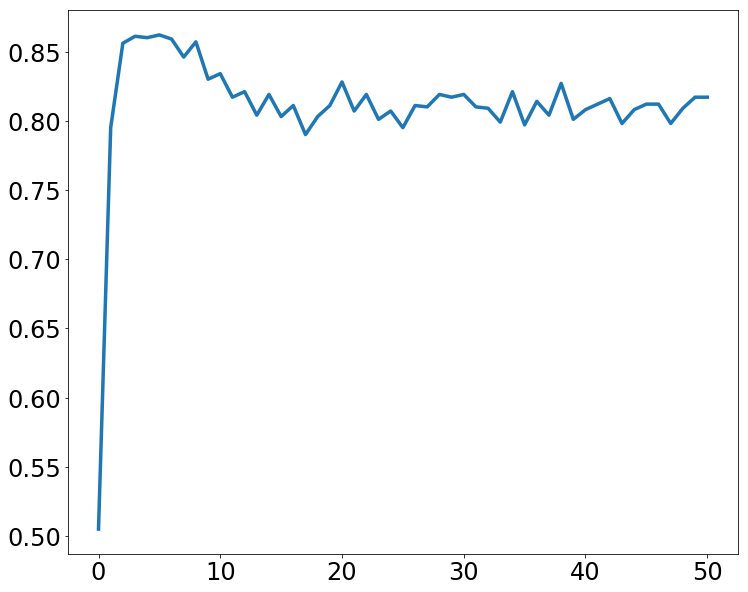

In [29]:
plt.figure(figsize=(12,10))
plt.plot(range(len(xs)), [accuracy(A, y, x) for x in xs], **kwargs)

## Sparse Inverse Covariance Estimation

Given a positive semidefinite matrix $S\in\mathbb{R}^n$ the objective function in sparse inverse covariance estimation is as follows:

$$ \min_{X\in\mathbb{R}^n\times n, X\succeq 0} 
\langle S, X\rangle - \log\det(X) + \alpha\|X\|_1
$$
Here, we define
$$\langle S, X\rangle = \mathrm{trace}(SX)$$
and
$$\|X\|_1 = \sum_{ij}|X_{ij}|.$$

Typically, we think of the matrix $S$ as a sample covariance matrix of a set of vectors $a_1,\dots, a_m,$ defined as:
$$
S = \frac1{m-1}\sum_{i=1}^n a_ia_i^\top
$$

In [30]:
import autograd.numpy as np
from autograd import grad 

In [31]:
def sparse_inv_cov(S, X, alpha=0.1):
    return (np.trace(S.dot(X))
            - np.log(np.linalg.det(X))
            + alpha * np.sum(np.abs(X)))

In [32]:
n = 5
A = np.random.normal(0, 1, (n, n))
S = A.dot(A.T)
objective = lambda X: sparse_inv_cov(S, X)
# autograd provides a "gradient", yay!
gradient = grad(objective)

We also need to worry about the projection onto the positive semidefinite cone, which corresponds to truncating eigenvalues.

In [33]:
def projection(X):
    """Projection onto positive semidefinite cone."""
    es, U = np.linalg.eig(X)
    es[es<0] = 0.
    return U.dot(np.diag(es).dot(U.T))

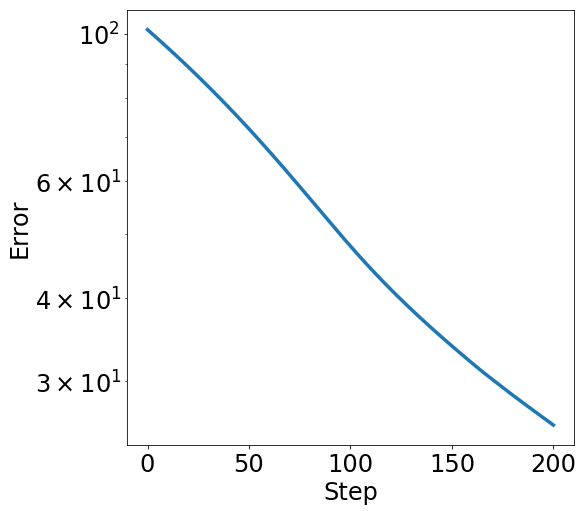

In [34]:
A0 = np.random.normal(0, 1, (n,n))
X0 = A0.dot(A0.T)
Xs = gradient_descent(X0, [0.01]*200, gradient, projection)
error_plot([objective(X) for X in Xs])

In [35]:
np.diagonal(S.dot(Xs[-1]))

array([ 9.14624857,  1.35763049,  3.53190923,  3.32170327,  4.66480481])